# MMC Implementation

## Correct Implementation

In [1]:
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import skmob
from tqdm import tqdm
import sys
sys.path.append('../')
from src.geo_utils import (get_clusters_from_tdf,
                            assign_tdf_points_to_clusters,
                            get_mmc_transitions,
                            get_stationary_vector)
import os

In [2]:
from src.geo_utils import (analyze_dates_with_events,
                           analyze_number_of_events, 
                           analyze_number_of_events_per_day, 
                           analyze_space_drift, 
                           analyze_speed_drift,
                           analyze_time_drift)

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def get_distance(row):
    lat, lng, lat_last, lng_last = row['lat'], row['lng'], row['lat_last'], row['lng_last']
    return skmob.utils.utils.distance((lat, lng), (lat_last, lng_last))

### Evaluation of Implementation

In [13]:
# Reading all the DataFrames and consolidating it into one
data_files = sorted([x for x in os.listdir('../data/') if 'geo_' in x])

data = pd.DataFrame()
for data_file in tqdm(data_files):
    data_i = pd.read_csv(f'../data/{data_file}')
    data = data.append(data_i)
data = data.reset_index(drop=True)

100%|██████████| 19/19 [01:16<00:00,  4.00s/it]


In [14]:
# Homogenizing the dataset format

geo_columns = ['user', 'hour', 'lat', 'lng']

data['hour'] = data['date'] + ' ' + data['time']
data['hour'] = pd.to_datetime(data['hour'])
data['user'] = data['user_id'].map(int)

data = data[geo_columns]
data = data.drop_duplicates()
data = data.groupby(['user','hour'], as_index=False).nth(0)
data = data.reset_index(drop=True)


# Estimating distance and time differences

data[['lat_last','lng_last']] = data.groupby('user').shift(1)[['lat','lng']]
data['seconds_diff'] = data.groupby('user')['hour'].diff(1).dt.seconds

data['distance_to_last_km'] = data.apply(get_distance, axis=1) 
data['speed_mps'] = data['distance_to_last_km'] / data['seconds_diff'] * 1000

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24178078 entries, 0 to 24178077
Data columns (total 9 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user                 int64         
 1   hour                 datetime64[ns]
 2   lat                  float64       
 3   lng                  float64       
 4   lat_last             float64       
 5   lng_last             float64       
 6   seconds_diff         float64       
 7   distance_to_last_km  float64       
 8   speed_mps            float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 1.6 GB


In [28]:
del data['lat_last'], data['lng_last']

In [29]:
data.head()

,user,hour,lat,lng,seconds_diff,distance_to_last_km,speed_mps
0,0,2008-10-23 02:53:04,39.984702,116.318417,NaN,NaN,NaN
1,0,2008-10-23 02:53:10,39.984683,116.318450,6.0,0.003517,0.586148
2,0,2008-10-23 02:53:15,39.984686,116.318417,5.0,0.002831,0.566260
3,0,2008-10-23 02:53:20,39.984688,116.318385,5.0,0.002735,0.547087
4,0,2008-10-23 02:53:25,39.984655,116.318263,5.0,0.011023,2.204602


- El 99% de los registros están distanciados entre 0 y 5 segundos

#### Saving Data

In [32]:
# Saving Data
data.to_parquet('../data/geolife_consolidated.parquet', index=False)

#### Loading Data (backup)

In [4]:
# Loading Data
data = pd.read_parquet('../data/geolife_consolidated.parquet')

In [10]:
data['date'] = data['hour'].dt.date

In [133]:
def analyze_time_drift(data):
    '''Analiza la distribución de la variación de tiempo (segundos) entre evento y evento'''
    
    # Distribución de número de eventos
    serie_seconds_events = data['seconds_diff'].value_counts()
    serie_seconds_events_log = np.log10(serie_seconds_events)

    print(serie_seconds_events)
    print()
    print(serie_seconds_events.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(1,2,1)
    data['seconds_diff'].hist(bins=100)
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Delta de Segundos')
    
    fig.add_subplot(1,2,2)

    serie_seconds_events_log.hist(bins=30)
    plt.title('Distribución de eventos según drift en segundos (log10)');
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Delta de Segundos (log10 scale)');
    

def analyze_space_drift(data):
    '''Analiza la distribución de la variación de distancia (Km) entre evento y evento'''

    serie_distance_events = data['distance_to_last_km'].value_counts()
    serie_distance_events_log = np.log10(serie_distance_events)
    
    print(serie_distance_events)
    print()
    print(serie_distance_events.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(1,2,1)
    data['distance_to_last_km'].hist(bins=100)
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Delta de KM');
    
    fig.add_subplot(1,2,2)

    serie_distance_events_log.hist(bins=30)
    plt.title('Distribución de eventos según drift de distancia (log10)');
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Delta de KM (log10 scale)');
    
    
def analyze_speed_drift(data):
    '''Analiza la velocidad (metros por segundo) de cada evento'''

    serie_speed = data['speed_mps']
    serie_speed_log = np.log10(serie_speed+1)
    
    print(serie_speed.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))
    
    fig.add_subplot(1,2,1)
    serie_speed.hist(bins=100)
    plt.title('Distribución de eventos según velocidad');
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Velocidad');
    
    fig.add_subplot(1,2,2)
    serie_speed_log.hist(bins=30)
    plt.title('Distribución de eventos según velocidad (log10)');
    plt.ylabel('Numero de Eventos')
    plt.xlabel('Velocidad (log10 scale)');
    
    
def analyze_number_of_events_per_day(data):
    '''Analiza la distribución de la variación de tiempo (segundos) entre evento y evento'''

    # Distribución de número de eventos
    df_events_per_day = data.groupby(['date','user'], as_index=False).size()
    
    serie_user_events_per_day = df_events_per_day['size']
    serie_user_events_per_day_log = np.log10(serie_user_events_per_day)

    print(serie_user_events_per_day)
    print()
    print(df_events_per_day['size'].quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))

    fig.add_subplot(1,2,1)
    serie_user_events_per_day.hist(bins=30)
    plt.title('Distribución de número de eventos por usuarios por día');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos en un día')    
    
    fig.add_subplot(1,2,2)
    serie_user_events_per_day_log.hist(bins=30)
    plt.title('Distribución de número de eventos por usuarios por día (log10)');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos en un día (log10 scale)')
    
def analyze_number_of_events(data):
    # Distribución de número de eventos
    serie_user_events = data['user'].value_counts()
    serie_user_events_log = np.log10(serie_user_events)

    print(serie_user_events)
    print()
    print(serie_user_events.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]))

    fig = plt.figure(figsize=(15,4))

    fig.add_subplot(1,2,1)
    serie_user_events.hist(bins=30)
    plt.title('Distribución de usuarios según Nro de Eventos');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos')    
    
    fig.add_subplot(1,2,2)
    serie_user_events_log.hist(bins=30)
    plt.title('Distribución de usuarios según Nro de Eventos (log10)');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos (log10 scale)')
    

def analyze_dates_with_events(data):
    # Distribución de número de eventos
    serie_user_events = data[['user','date']].drop_duplicates()['user'].value_counts()
    serie_user_events_log = np.log10(serie_user_events)

    print(serie_user_events)

    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(1,2,1)
    serie_user_events.hist(bins=30)
    plt.title('Distribución de usuarios según Nro de Días con Eventos');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de Días con eventos')
    
    fig.add_subplot(1,2,2)

    serie_user_events_log.hist(bins=30)
    plt.title('Distribución de usuarios según Nro de Días con Eventos (log10)');
    plt.ylabel('Numero de Usuarios')
    plt.xlabel('Número de eventos (log10 scale)')

153    2156964
128    1208309
41     1057038
17     1026176
163     969084
        ...   
171        177
87         152
178         84
72          81
60          17
Name: user, Length: 182, dtype: int64

0.10        718.90
0.20       2534.00
0.30       6851.40
0.40      14677.40
0.50      35181.50
0.60      55863.80
0.70      90573.50
0.80     175329.20
0.90     386695.30
0.95     608317.60
0.99    1085779.49
1.00    2156964.00
Name: user, dtype: float64


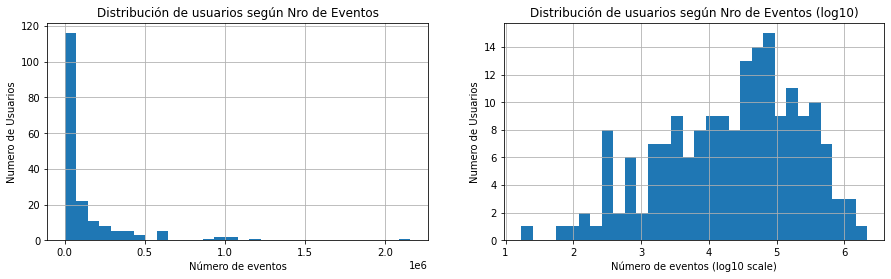

In [124]:
analyze_number_of_events(data)

0          3
1         28
2         58
3          9
4         55
        ... 
11142    730
11143    789
11144    871
11145    319
11146    296
Name: size, Length: 11147, dtype: int64

0.00        1.0
0.10      133.6
0.20      352.0
0.30      565.0
0.40      818.0
0.50     1168.0
0.60     1629.0
0.70     2306.0
0.80     3273.0
0.90     5099.4
0.95     7094.4
0.99    14375.0
1.00    59767.0
Name: size, dtype: float64


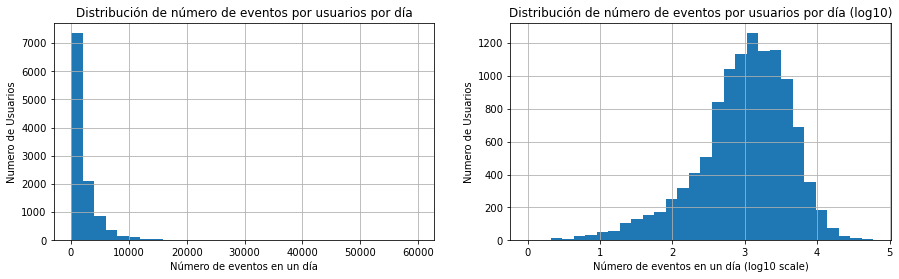

In [122]:
analyze_number_of_events_per_day(data)

153    1273
128     909
163     552
144     341
68      297
       ... 
49        1
143       1
151       1
178       1
149       1
Name: user, Length: 182, dtype: int64


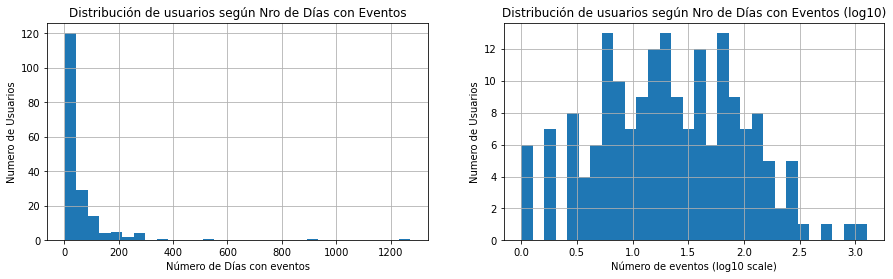

In [125]:
analyze_dates_with_events(data)

0.000000    866584
0.000111     84731
0.000111     50325
0.000222     34681
0.000334     26409
             ...  
0.000085         1
0.011193         1
0.018471         1
0.006466         1
0.015240         1
Name: distance_to_last_km, Length: 20782581, dtype: int64

0.00         1.0
0.10         1.0
0.20         1.0
0.30         1.0
0.40         1.0
0.50         1.0
0.60         1.0
0.70         1.0
0.80         1.0
0.90         1.0
0.95         2.0
0.99         2.0
1.00    866584.0
Name: distance_to_last_km, dtype: float64


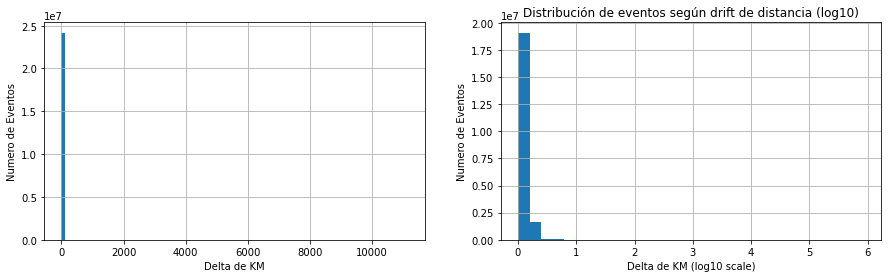

In [127]:
analyze_space_drift(data)

0.000000    866584
0.000111     84731
0.000111     50325
0.000222     34681
0.000334     26409
             ...  
0.000085         1
0.011193         1
0.018471         1
0.006466         1
0.015240         1
Name: distance_to_last_km, Length: 20782581, dtype: int64

0.00         1.0
0.10         1.0
0.20         1.0
0.30         1.0
0.40         1.0
0.50         1.0
0.60         1.0
0.70         1.0
0.80         1.0
0.90         1.0
0.95         2.0
0.99         2.0
1.00    866584.0
Name: distance_to_last_km, dtype: float64


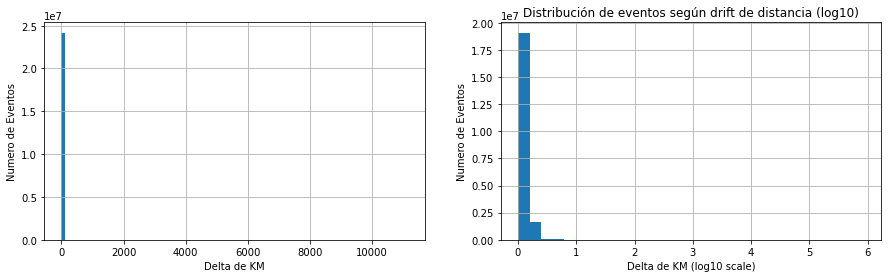

In [128]:
analyze_space_drift(data)

0.00    0.000000e+00
0.10    1.853249e-01
0.20    7.215687e-01
0.30    1.284613e+00
0.40    2.109767e+00
0.50    3.782965e+00
0.60    6.744371e+00
0.70    1.058748e+01
0.80    1.472791e+01
0.90    2.090978e+01
0.95    2.857725e+01
0.99    4.167644e+01
1.00    1.963235e+06
Name: speed_mps, dtype: float64


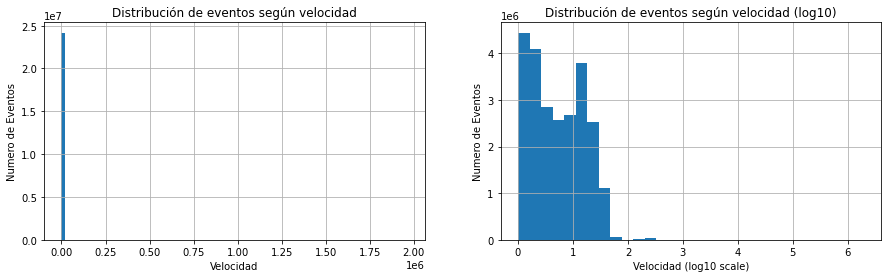

In [129]:
analyze_speed_drift(data)

#### Latitud y Longitud

<AxesSubplot:>

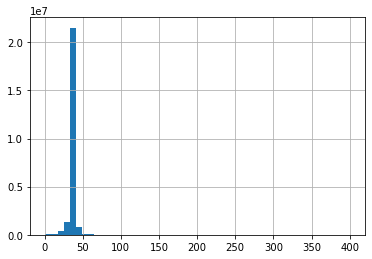

In [105]:
data['lat'].hist(bins=50)

<AxesSubplot:>

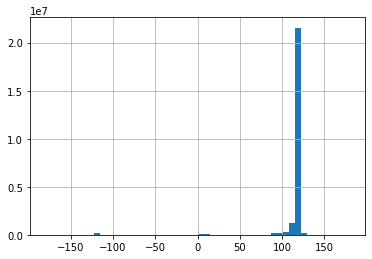

In [106]:
data['lng'].hist(bins=50)

In [28]:
data.shape

(24178078, 7)

- Datashader

In [38]:
dd = data.sample(20000)

In [31]:
import seaborn as sns

<AxesSubplot:xlabel='lng', ylabel='lat'>

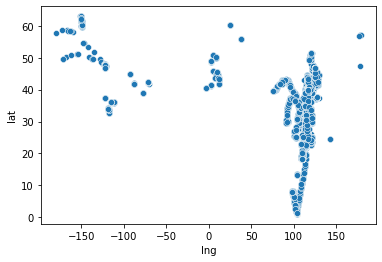

In [35]:
sns.scatterplot(data=dd, x='lng', y='lat')

<AxesSubplot:xlabel='lat', ylabel='lng'>

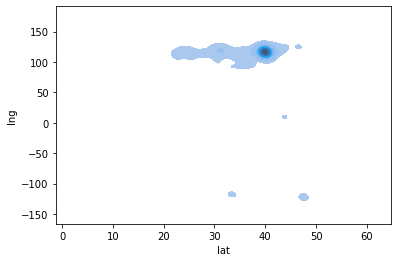

In [39]:
sns.kdeplot(data=dd, x='lat', y='lng', fill=True)

__Escenarios:__
- Base
- Filtro por país
- Filtro por tiempo en lugar

__Acuerdos__
- Quitar usuarios con menos de 1000 eventos
- Probar los 3 escenarios

In [35]:
aux_dict = {}
aux_dict['user'] = []
aux_dict['number_points'] = []
aux_dict['min_tmstmp'] = []
aux_dict['max_tmstmp'] = []
for usr in data['user'].unique():
    aux_dict['user'].append(usr)
    aux_dict['number_points'].append(data[data['user']==usr].shape[0])
    aux_dict['min_tmstmp'].append(data[data['user']==usr]['hour'].min())
    aux_dict['max_tmstmp'].append(data[data['user']==usr]['hour'].max())
aux_dict = pd.DataFrame(aux_dict)
aux_dict['duracion'] = (aux_dict['max_tmstmp'] - aux_dict['min_tmstmp']).dt.total_seconds()/ 60
aux_dict.sort_values(by='duracion', ascending=True, inplace=True)
display(aux_dict)

,user,number_points,min_tmstmp,max_tmstmp,duracion
8,8,77908,2008-10-24 11:48:34,2008-12-12 09:24:41,70416.116667
6,6,31830,2008-10-23 06:59:39,2008-12-11 08:22:35,70642.933333
7,7,85531,2008-10-25 14:22:00,2008-12-15 11:38:45,73276.750000
9,9,84615,2008-10-24 10:15:35,2008-12-14 11:18:09,73502.566667
1,1,108607,2008-10-23 05:53:05,2008-12-15 00:31:18,75998.216667
5,5,109046,2008-10-24 04:12:30,2009-03-19 05:46:37,210334.116667
2,2,248214,2008-10-23 12:45:23,2009-03-22 08:13:37,215728.233333
3,3,485226,2008-10-23 17:58:54,2009-07-05 07:45:15,366586.350000
0,0,173870,2008-10-23 02:53:04,2009-07-05 07:45:15,367492.183333
4,4,439397,2008-10-23 17:58:52,2009-07-29 06:16:11,401057.316667


Text(0, 0.5, 'Cantidad de puntos')

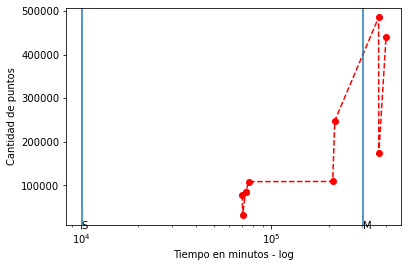

In [72]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_xscale('log')
plt.scatter(aux_dict['duracion'].values, aux_dict['number_points'].values, color='r')
plt.plot(aux_dict['duracion'].values, aux_dict['number_points'].values , color='r', linestyle='--')
"""
plt.axvline(60,0)
plt.text(60,0, 'H')
plt.axvline(60*24,0)
plt.text(60*24,0, 'D')
"""
plt.axvline(60*24*7,0)
plt.text(60*24*7,0, 'S')
plt.axvline(60*24*7*30,0)
plt.text(60*24*7*30,0, 'M')
ax.set_xlabel('Tiempo en minutos - log')
ax.set_ylabel('Cantidad de puntos')
#plt.axvline(60*24*7*30*365,0)
#plt.text(60*24*7*30*365,0, 'Y')
#plt.show()

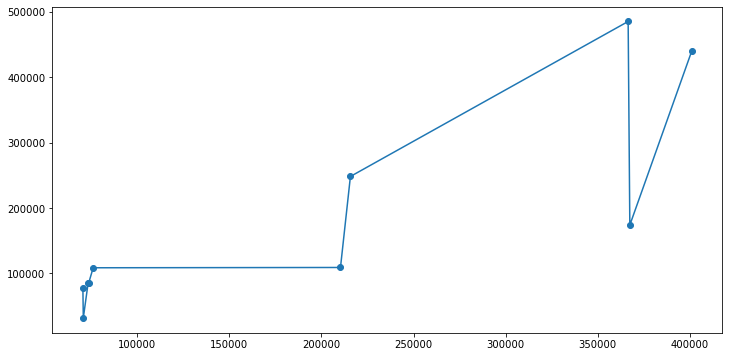

In [60]:
fig,ax = plt.subplots(figsize=(12,6))
#ax.set_xscale('log')
plt.scatter(aux_dict['duracion'].values, aux_dict['number_points'].values)
plt.plot(aux_dict['duracion'].values, aux_dict['number_points'].values )

#plt.show()

In [94]:
data['seconds_diff'].nlargest(30)

11580681    86399.0
18592681    86395.0
1851493     86392.0
6921679     86378.0
20529931    86372.0
10778081    86365.0
11806805    86308.0
5152752     86303.0
3838058     86271.0
5125359     86267.0
19572773    86243.0
21691417    86200.0
23352351    86193.0
12906024    86180.0
7096056     86167.0
22533998    86156.0
17397606    86149.0
13930227    86122.0
23675555    86109.0
24006514    86102.0
20472012    86096.0
14311540    86050.0
21283145    86050.0
7614        86049.0
21765454    86044.0
5495778     86039.0
13865856    86028.0
23676659    86024.0
14053440    86019.0
12214245    86015.0
Name: seconds_diff, dtype: float64

-------|-----|-----------|---------|

--xxXx--|--xX-x--|--x--xX--|

In [15]:
data['distance_to_last_km'].nlargest(30)

1525575    2001.218375
1520070    1994.344900
97123      1081.669208
939173     1081.669208
1346992    1081.536654
150130     1077.944217
992180     1077.944217
1352858    1076.852294
160679     1075.844012
1002729    1075.844012
102798     1075.794203
944848     1075.794203
834474      572.986636
423067      541.871785
1170042     442.393688
1558080     426.398341
1560352     426.291883
750317      394.941580
447718      231.795536
847476      190.899617
446666      165.851492
1569640     118.908134
1569088      90.527781
1616976      77.289171
1612317      71.716266
447251       64.190462
1596208      30.764803
460192       26.282796
1649785      22.989909
673294       22.801299
Name: distance_to_last_km, dtype: float64